# RANDOM CROSS VALIDATION

## MODEL SELECTION

In [1]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [2]:
to_pedix = str.maketrans("3", "₃")

In [3]:
import xarray as xr

nh3_nc = xr.load_dataset('../datasets/CAMS-GLOB-ANT_Glb_0.1x0.1_anthro_nh3_v4.2_monthly_lombardia.nc') # Copernicus (0.1°x0.1°)

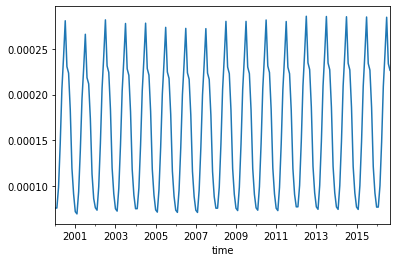

In [4]:
from utils import utils
import matplotlib.pyplot as plt

nh3 = utils.xarray2pandas(nh3_nc.agl, 6, 17).to_period('M')

train_data, test_data = utils.ts_train_test_split(nh3, .8)

train_data.plot()
plt.show()

In [5]:
import random

random.seed(0)

def random_training_validation_window(ts, size, validation_size):

    n = len(ts)

    start = random.randint(0, int(n*(1-size)) - validation_size)
    end = start + int(n*size)
    return ts[start:end], ts[end:end+validation_size]

In [6]:
def multiple_forecasts(model, ts, times, refit=False):
    
    predictions = []
    errors = []

    for i in range(len(ts)):
        prediction = model.forecast()
        model = model.append([prediction.values[0]], refit=refit)
        predictions.append(prediction.values[0])
        errors.append(ts.values[i] - prediction.values[0])
    
    return predictions, errors

In [7]:
def autocorr(ts):
    errors = pd.Series(ts)
    n = len(ts)
    data = np.asarray(ts)
    mean = np.mean(data)
    c0 = np.sum((data - mean) ** 2) / float(n)

    def r(h):
        return ((data[:n - h] - mean) * (data[h:] - mean)).sum() / float(n) / c0

    lags = np.arange(n) + 1
    return list(map(r, lags))

In [8]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
import pandas as pd

def random_cross_validation(ts, order, seasonal_order, times=1, verbose=False):

    aics = []
    bics = []
    rmses = []
    resid_acfs = []

    for i in range(times):
        train_months = 180
        validation_months = 12
        train_data, validation_data = random_training_validation_window(nh3, train_months/len(nh3), validation_months)

        assert(len(train_data) == train_months)
        assert(len(validation_data) == validation_months)

        model = ARIMA(endog=train_data, order=order, seasonal_order=seasonal_order).fit()

        aics.append(model.aic)
        bics.append(model.bic)

        # prediction out of sample
        predictions, errors = multiple_forecasts(model=model, ts=validation_data, times=len(validation_data), refit=False)
        rmse = np.sqrt(np.mean(((predictions - validation_data.values) ** 2)))
        rmses.append(rmse)

        resid_acf = np.mean(np.abs(acf(model.resid, nlags=24)))
        resid_acfs.append(resid_acf)

    return np.mean(aics), np.mean(bics), np.mean(rmses), np.mean(resid_acfs)

In [9]:
# SARIMAX(p,d,q,P,D,Q,s)

import numpy as np

def model_selection(ts, cv_iterations=1, verbose=False):
    
    p_list = [1, 2, 3, 4]
    q_list = [0, 1, 2]
    P_list = [1]
    Q_list = [0, 1]
    s_list = [12]

    results = {}
    idx = 0

    for p in p_list:
       for q in q_list:
            for P in P_list:
                for Q in Q_list:
                    for s in s_list:
                        model_name = 'SARIMA(p={}, d=0, q={}, P={}, D=0, Q={}, s={})'.format(p, q, P, Q, s)
                        model_idx = idx

                        if verbose: print('{}: {}'.format(model_idx, model_name))
                        
                        aic, bic, rmse, resid_acf = random_cross_validation(ts=ts, order=(p,0,q), seasonal_order=(P,0,Q,s), times=cv_iterations)

                        results[model_name] = {
                            'index' : model_idx,
                            'order' : (p,0,q),
                            'seasonal_order' : (P,0,Q,s),
                            'aic' : aic,
                            'bic' : bic,
                            'rmse' : rmse,
                            'acf': resid_acf
                            }

                        idx += 1
                    
                    
    return results

In [10]:
results = model_selection(train_data, cv_iterations=10, verbose=True)

0: SARIMA(p=1, d=0, q=0, P=1, D=0, Q=0, s=12)
1: SARIMA(p=1, d=0, q=0, P=1, D=0, Q=1, s=12)
2: SARIMA(p=1, d=0, q=1, P=1, D=0, Q=0, s=12)
3: SARIMA(p=1, d=0, q=1, P=1, D=0, Q=1, s=12)
4: SARIMA(p=1, d=0, q=2, P=1, D=0, Q=0, s=12)
5: SARIMA(p=1, d=0, q=2, P=1, D=0, Q=1, s=12)
6: SARIMA(p=2, d=0, q=0, P=1, D=0, Q=0, s=12)
7: SARIMA(p=2, d=0, q=0, P=1, D=0, Q=1, s=12)
8: SARIMA(p=2, d=0, q=1, P=1, D=0, Q=0, s=12)
9: SARIMA(p=2, d=0, q=1, P=1, D=0, Q=1, s=12)
10: SARIMA(p=2, d=0, q=2, P=1, D=0, Q=0, s=12)
11: SARIMA(p=2, d=0, q=2, P=1, D=0, Q=1, s=12)
12: SARIMA(p=3, d=0, q=0, P=1, D=0, Q=0, s=12)
13: SARIMA(p=3, d=0, q=0, P=1, D=0, Q=1, s=12)
14: SARIMA(p=3, d=0, q=1, P=1, D=0, Q=0, s=12)
15: SARIMA(p=3, d=0, q=1, P=1, D=0, Q=1, s=12)
16: SARIMA(p=3, d=0, q=2, P=1, D=0, Q=0, s=12)
17: SARIMA(p=3, d=0, q=2, P=1, D=0, Q=1, s=12)
18: SARIMA(p=4, d=0, q=0, P=1, D=0, Q=0, s=12)
19: SARIMA(p=4, d=0, q=0, P=1, D=0, Q=1, s=12)
20: SARIMA(p=4, d=0, q=1, P=1, D=0, Q=0, s=12)
21: SARIMA(p=4, d=0, q=

In [38]:
aics = [v['aic'] for k, v in results.items()]
bics = [v['bic'] for k, v in results.items()]
rmses = [v['rmse'] for k, v in results.items()]
acfs = [v['acf'] for k, v in results.items()]

In [39]:
def tick(order, seasonal_order):
    p, d, q = order
    P, D, Q, s = seasonal_order
    return str((p,q,P,Q))

ticks = [tick(v['order'], v['seasonal_order']) for k, v in sorted(results.items(), key=lambda item: item[1]['index'])]

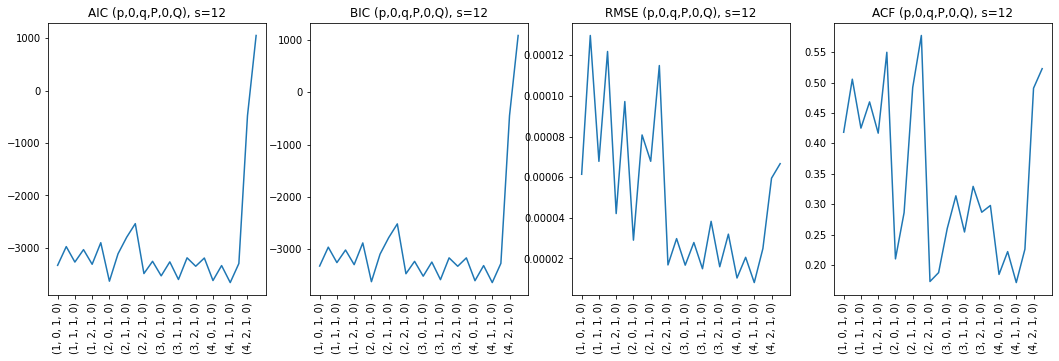

In [41]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(18,5))
indices = np.arange(0, len(results), 2)

axs[0].plot(aics)
axs[0].set_title('AIC (p,0,q,P,0,Q), s=12')
axs[0].set_xticks(indices)
axs[0].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[1].plot(bics)
axs[1].set_title('BIC (p,0,q,P,0,Q), s=12')
axs[1].set_xticks(indices)
axs[1].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[2].plot(rmses)
axs[2].set_title('RMSE (p,0,q,P,0,Q), s=12')
axs[2].set_xticks(indices)
axs[2].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[3].plot(acfs)
axs[3].set_title('ACF (p,0,q,P,0,Q), s=12')
axs[3].set_xticks(indices)
axs[3].set_xticklabels(np.array(ticks)[indices], rotation=90)

plt.show()

In [14]:
print('min AIC: {}, min BIC {}, min RMSE {}, min ACF'.format(np.argmin(aics), np.argmin(bics), np.argmin(rmses), np.argmin(bics)))

min AIC: 20, min BIC 20, min RMSE 20, min ACF


In [15]:
min_aic_model = [v for k,v in results.items() if v['aic'] == np.min(aics)][0]
min_aic_model

{'index': 20,
 'order': (4, 0, 1),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -3660.665529945989,
 'bic': -3635.1218751388674,
 'rmse': 8.12173478391358e-06,
 'acf': 0.17139744709392865}

In [16]:
min_bic_model = [v for k,v in results.items() if v['bic'] == np.min(bics)][0]
min_bic_model

{'index': 20,
 'order': (4, 0, 1),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -3660.665529945989,
 'bic': -3635.1218751388674,
 'rmse': 8.12173478391358e-06,
 'acf': 0.17139744709392865}

In [17]:
min_rmse_model = [v for k,v in results.items() if v['rmse'] == np.min(rmses)][0]
min_rmse_model

{'index': 20,
 'order': (4, 0, 1),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -3660.665529945989,
 'bic': -3635.1218751388674,
 'rmse': 8.12173478391358e-06,
 'acf': 0.17139744709392865}

In [18]:
min_acf_model = [v for k,v in results.items() if v['acf'] == np.min(acfs)][0]
min_acf_model

{'index': 20,
 'order': (4, 0, 1),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -3660.665529945989,
 'bic': -3635.1218751388674,
 'rmse': 8.12173478391358e-06,
 'acf': 0.17139744709392865}

In [19]:
# select models with aic near the minimum found
min_aic = np.min(aics)
candidate_models = [v for k,v in results.items() if v['aic'] < min_aic*0.95 ]

In [20]:
aics = [v['aic'] for v in candidate_models]
bics = [v['bic'] for v in candidate_models]
rmses = [v['rmse'] for v in candidate_models]
acfs = [v['acf'] for v in candidate_models]

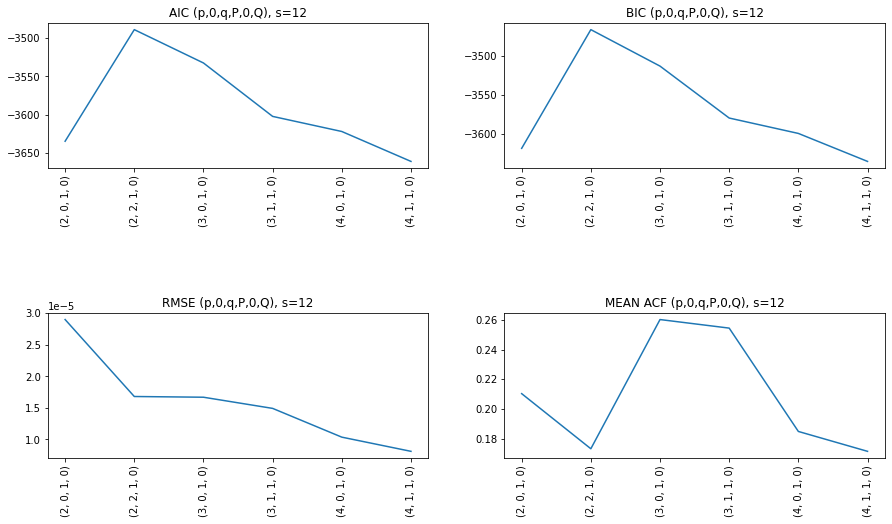

In [21]:
ticks = [tick(v['order'], v['seasonal_order']) for v in candidate_models]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,8))
indices = np.arange(0, len(candidate_models), 1)

fig.subplots_adjust(hspace=1)

axs[0,0].plot(aics)
axs[0,0].set_title('AIC (p,0,q,P,0,Q), s=12')
axs[0,0].set_xticks(indices)
axs[0,0].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[0,1].plot(bics)
axs[0,1].set_title('BIC (p,0,q,P,0,Q), s=12')
axs[0,1].set_xticks(indices)
axs[0,1].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[1,0].plot(rmses)
axs[1,0].set_title('RMSE (p,0,q,P,0,Q), s=12')
axs[1,0].set_xticks(indices)
axs[1,0].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[1,1].plot(acfs)
axs[1,1].set_title('MEAN ACF (p,0,q,P,0,Q), s=12')
axs[1,1].set_xticks(indices)
axs[1,1].set_xticklabels(np.array(ticks)[indices], rotation=90)

plt.show()

In [22]:
# selezionato il modello migliore....

In [42]:
model = ARIMA(train_data, order=min_aic_model['order'], seasonal_order=min_aic_model['seasonal_order']).fit()

In [43]:
pd.DataFrame([model.params, model.pvalues], ['value', 'pvalue'])

,const,ar.L1,ar.L2,ar.S.L12,sigma2
value,0.000164,1.447471,-0.725511,0.999238,5.640314e-12
pvalue,0.229001,0.000000,0.000000,0.000000,9.674473e-01


## RESIDUAL ANALYSIS

In [56]:
best_model = ARIMA(train_data, order=min_aic_model['order'], seasonal_order=min_rmse_model['seasonal_order']).fit()

## Out-of-sample predictions

In [57]:
predictions, errors = multiple_forecasts(model=best_model, ts=test_data, times=len(test_data), refit=False)

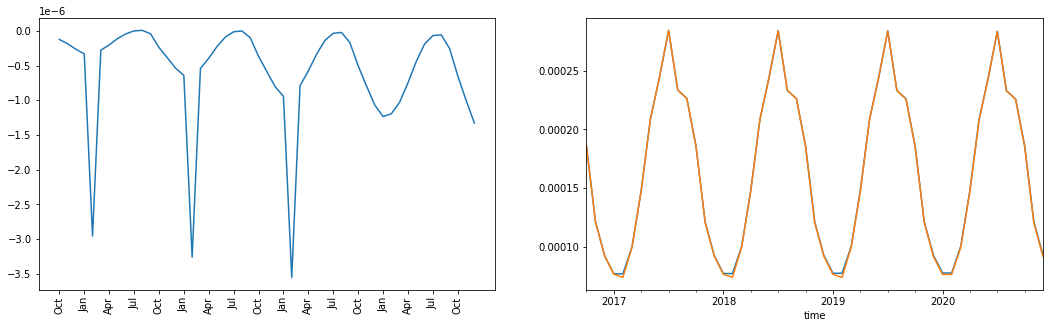

In [58]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,5))

indices = np.arange(0, len(test_data), 3)
ticks = [date.strftime('%b') for date in test_data.index]
axs[0].set_xticks(indices)
axs[0].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[0].plot(errors)

pd.Series(predictions, index=test_data.index).plot(ax=axs[1])
test_data.plot(ax=axs[1])
plt.show()

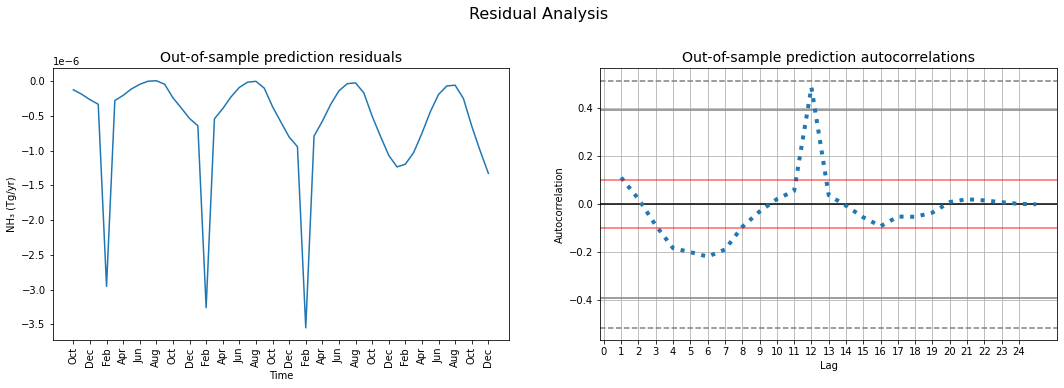

In [59]:
from pandas.plotting import autocorrelation_plot

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,5))
fig.suptitle('Residual Analysis', fontsize=16, y=1.05)

axs[0].plot(errors)
axs[0].set_title('Out-of-sample prediction residuals', fontsize=14)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('NH3 (Tg/yr)'.translate(to_pedix))

indices = np.arange(0, len(test_data), 2)
ticks = [date.strftime('%b') for date in test_data.index]
axs[0].set_xticks(indices)
axs[0].set_xticklabels(np.array(ticks)[indices], rotation=90)

lags = 25
autocorrelation_plot(errors[:lags], ax=axs[1], linestyle='dotted', linewidth=4)
axs[1].set_title('Out-of-sample prediction autocorrelations', fontsize=14)

axs[1].axhline(y=-0.1, color='r', linestyle='-', alpha=.6)
axs[1].axhline(y=0.1, color='r', linestyle='-', alpha=.6)

indices = np.arange(0, lags, 1)
axs[1].set_xticks(indices)
axs[1].set_xticklabels(indices)

plt.show()

### In-Sample prediction errors

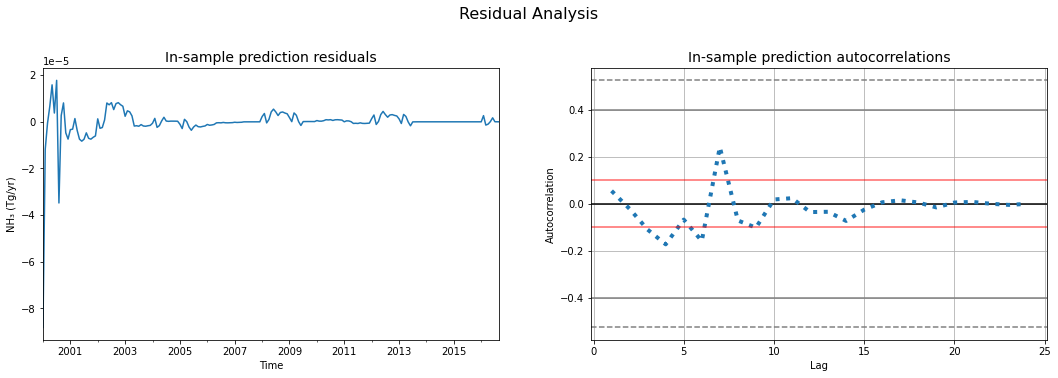

In [29]:
errors = best_model.resid

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,5))
fig.suptitle('Residual Analysis', fontsize=16, y=1.05)

pd.Series(errors).plot(ax=axs[0])
axs[0].set_title('In-sample prediction residuals', fontsize=14)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('NH3 (Tg/yr)'.translate(to_pedix))

autocorrelation_plot(errors[:24], ax=axs[1], linestyle='dotted', linewidth=4)
axs[1].set_title('In-sample prediction autocorrelations', fontsize=14)

axs[1].axhline(y=-0.1, color='r', linestyle='-', alpha=.6)
axs[1].axhline(y=0.1, color='r', linestyle='-', alpha=.6)

plt.show()

best_model.plot_diagnostics(figsize=(10,10))
plt.show()

Excluding the first 12 months due to seasonality

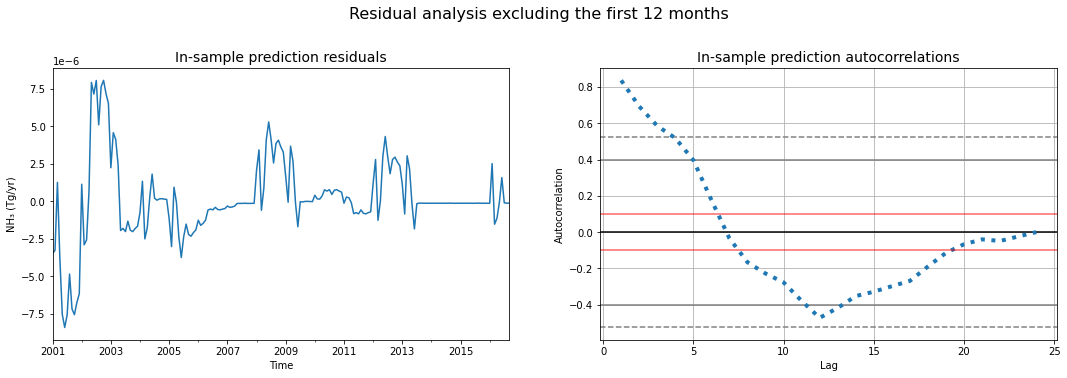

In [30]:
predictions = best_model.predict(start=train_data.index[12], end=train_data.index[-1])

errors = train_data[12:].values - predictions.values

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,5))
fig.suptitle('Residual analysis excluding the first 12 months', fontsize=16,  y=1.05)

pd.Series(errors, index=predictions.index).plot(ax=axs[0])
axs[0].set_title('In-sample prediction residuals', fontsize=14)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('NH3 (Tg/yr)'.translate(to_pedix))

autocorrelation_plot(errors[:24], ax=axs[1], linestyle='dotted', linewidth=4)
axs[1].set_title('In-sample prediction autocorrelations', fontsize=14)

axs[1].axhline(y=-0.1, color='r', linestyle='-', alpha=.6)
axs[1].axhline(y=0.1, color='r', linestyle='-', alpha=.6)

plt.show()

### Autocorrelation

Ljung-box test

Checks if residuals are white noise:
* Accept H0 = no autocorrelations between the series and its first `lags` 
* Reject H0 = autocorrelations between the series and its first `lags` 

In [31]:
from statsmodels.stats.diagnostic import acorr_ljungbox

model_df = len(best_model.param_names) # degrees of freedom of the model

lbvalue, pvalue = acorr_ljungbox(errors, lags=12, model_df=model_df)

alpha = 0.05
print(['Correlated' for i in pvalue[pd.notna(pvalue)] if i < alpha])

['Correlated', 'Correlated', 'Correlated', 'Correlated']


### Normality

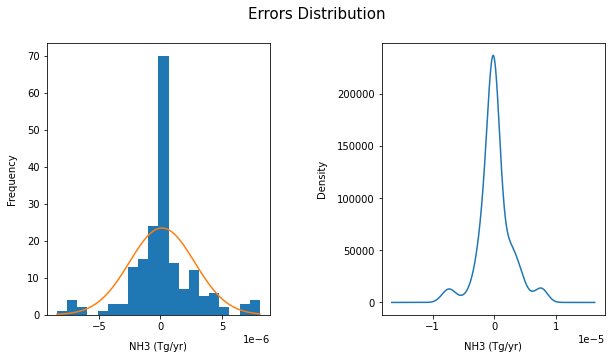

jarque bera test: not normally distributed, pvalue: 5.6707999428210755e-11
lilliefors test: not normally distributed, pvalue: 0.0009999999999998899


In [32]:
from utils.plots import plot_distributions
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import lilliefors

plot_distributions(pd.Series(errors), 'Errors Distribution', ['NH3 (Tg/yr)','NH3 (Tg/yr)'])

jb, pvalue, sk, k = jarque_bera(errors)
print('jarque bera test: {}, pvalue: {}'.format('normally distributed' if pvalue > 0.05 else 'not normally distributed', pvalue))

ksstat, pvalue = lilliefors(errors)
print('lilliefors test: {}, pvalue: {}'.format('normally distributed' if pvalue > 0.05 else 'not normally distributed', pvalue))

In [33]:
#  null hypothesis is of no heteroskedasticity

result = best_model.test_heteroskedasticity(method=None)

if result[0, 1] < 0.05: print('Residui eteroschedastici') 
else: print('Residui moschedastici')
print('pvalue: ', result[0,1])

Residui eteroschedastici
pvalue:  1.0350455016835155e-15
